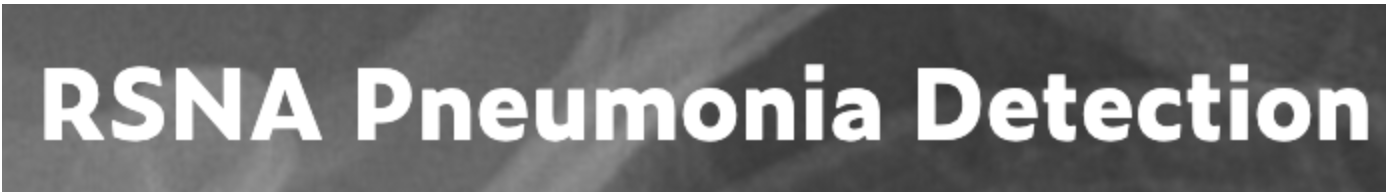
<center>
<span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#9900ff"> <h3> Pneumonia Detection Using computer vision
</center>
<div>
    <span style="font-family: Arial; font-weight:bold;color:#ff00ff">

##### OverView:
    Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments [1] and over 50,000 deaths in 2015 [2], keeping the ailment on the list of top 10 causes of death in the country.
    While common, accurately diagnosing pneumonia is a tall order. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity [3] on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.
        CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR [4], complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
        The RSNA is an international society of radiologists, medical physicists and other medical professionals with more than 54,000 members from 146 countries across the globe. They see the potential for ML to automate initial detection (imaging screening) of potential pneumonia cases in order to prioritize and expedite their review.
        
##### Objective:
    In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

##### Exploratory Data Analysis
    - Univariate Analysis - Outlier and Frequency Analysis
    - Bivariate Analysis - Visu**alization
    - Variable Reduction - Multicollinearity

##### Data Pre-Processing - 
    - Missing Values Treatment 
    - The IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:
        𝐼𝑜𝑈(𝐴,𝐵)=𝐴∩𝐵𝐴∪𝐵.
    -The average precision of a single image is calculated as the mean of the above precision values at each IoU  threshold =   1|𝑡ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑𝑠|∑𝑡𝑇𝑃(𝑡)𝑇𝑃(𝑡)+𝐹𝑃(𝑡)+𝐹𝑁(𝑡).
    
##### Model Build and Model Diagnostics
    - Train and Test split
    - MobileNet
    - Resnet50
    - DenseNet121

##### Model Validation
       -Dice Coeffiecient
       -Precision
       -Accuracy
    - 
##### Choose the best model
    -  yet to tune the models


</div>

**Import the Necessary Libraries**

In [ ]:
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pydicom as dcm
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from matplotlib.patches import Rectangle
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow
from tensorflow.keras.layers import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import gc
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

**Load Datasets**

In [ ]:
label_data = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [ ]:
label_data.head()

In [ ]:
class_info = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")

In [ ]:
class_info.head(4)

In [ ]:
df = pd.merge(left = class_info, right = label_data, how = 'left', on = 'patientId')
df = df.drop_duplicates()
df.info()

**Database table Preprocessing**

In [ ]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data # return the dataframe

In [ ]:
check_for_missing_data(label_data)

In [ ]:
check_for_missing_data(class_info)

No missing value found in the class_info table

All the target values are filled therefore there is no empty value, cell with Nan or empty cell are having no phenumonia so we should replace those value with 0

In [ ]:
label_data.fillna(0, inplace=True)

In [ ]:
label_data.info()

x, y, width, height are float type therefore we can say that they all have the numerical values

In [ ]:
label_data[label_data["Target"]==1].describe().T

from here we can get an idea of mean width and mean height of the phenumoniatic image areas

In [ ]:
np.unique(class_info["class"])

We can divide the dataset in 3 classes

1. confirmed phenumoia
2. partial phenumonia
3. Normal Lungs

In [ ]:
np.unique(label_data["Target"])

In [ ]:
sns.countplot(label_data["Target"])


We may need to upsample 1 so that the model doesn't biase

In [ ]:
sns.countplot(class_info["class"])

In [ ]:
class_info[class_info["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

In [ ]:
label_data[label_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

No Lung Opacity / Not Normal has been classified as Target 0

In [ ]:
class_info[class_info["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

In [ ]:
label_data[label_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

Noraml has been classified as 0 too

In [ ]:
class_info[class_info["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

In [ ]:
label_data[label_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

Lung Opacity has been classified as 1 and other classes has been classified as Normal indicated as 0

The class value 'No Lung Opacity / Not Normal ' is classified as 0 as it could be case of other complication which is not phenumonia

In [ ]:
pd.pivot_table(df,index=["class"], values=['patientId'], aggfunc='count')

In [ ]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_meta_Data = pd.DataFrame(columns=column_list)

In [ ]:
def add_meta_data_to_df(df, loc, from_list):
    data = []
    for filename in from_list:
            imagePath = loc+filename
            data_row_img_data = dcm.read_file(imagePath)
            values = []
            values.append(data_row_img_data.PatientID)
            values.append(data_row_img_data.PatientSex)
            values.append(data_row_img_data.PatientAge)
            values.append(data_row_img_data.ViewPosition)
            values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
            zipped_val = dict(zip(column_list, values))
            df = df.append(zipped_val, True)
    return df

In [ ]:
# Images Example
train_images_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

In [ ]:
file_meta_Data = add_meta_data_to_df(file_meta_Data, "../input/rsna-pneumonia-detection-challenge/stage_2_train_images/", train_images)

In [ ]:
file_meta_Data.info()

In [ ]:
df["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)
plt.show()

In [ ]:
sns.countplot(file_meta_Data['View Position'])

We have 2 view positions in the images

In [ ]:
sns.distplot(file_meta_Data["Patient's Age"])

In [ ]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Now we have to count of Train and Test Data here

In [ ]:
dicom_file_path = os.path.join("../input/rsna-pneumonia-detection-challenge/stage_2_train_images/05eebe4c-bca2-40d4-bb20-54fc60e2bcea.dcm")
file = dcm.read_file(dicom_file_path)
file

The above gives more information on the individual data, but in our modeling case these are not relevant

**Data Visualisation**

In [ ]:
gc.collect()

In [ ]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"../input/rsna-pneumonia-detection-challenge/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target']))
        rows = label_data[label_data['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

In [ ]:
def show_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"../input/rsna-pneumonia-detection-challenge/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

Let display some images that has been classified as a case of phenumonia

In [ ]:
show_images(label_data[label_data['Target']==1].sample(9))

Also display the image of normal lungs so that we can have idea about how normal lungs will look

In [ ]:
show_images(label_data[label_data['Target']==0].sample(9))

In [ ]:
show_dicom_images_with_boxes(label_data[label_data['Target']==1].sample(9))

In [ ]:
class_info[class_info['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

In [ ]:
class_info.drop_duplicates(subset='patientId', keep='last', inplace=True)

In [ ]:
class_info.shape

In [ ]:
IMAGE_SIZE = 1024#sample_pixel_array.shape[0]
ADJUSTED_IMAGE_SIZE=224
MASK_IMAGE_SIZE = 28
FACTOR = MASK_IMAGE_SIZE/IMAGE_SIZE

In [ ]:
class_info = shuffle(class_info)

In [ ]:
class_train, class_val = train_test_split(class_info, test_size=0.10, random_state=42, stratify=class_info['class'])

In [ ]:
X_feature_tr = []
y_feature_target_tr = []
y_feature_coordinates_tr = []
from PIL import Image

Now let's create the mask images are per the given coordinates

In [ ]:
def create_mask(datafm):
    X = []
    y=[]
    masks = np.zeros((int(datafm.shape[0]), MASK_IMAGE_SIZE, MASK_IMAGE_SIZE))
    for index, patient_id in enumerate(datafm['patientId'].T.to_dict().values()):
        image_path = train_images_dir+patient_id+".dcm"
        img = dcm.read_file(image_path)
        img = img.pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = preprocess_input(np.array(img, dtype=np.float32))
        X.append(img)
        rows = label_data[label_data['patientId']==patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x']*FACTOR)
            x2 = int((row['x']*FACTOR)+(row['width']*FACTOR))
            y1 = int(row['y']*FACTOR)
            y2 = int((row['y']*FACTOR)+(row['height']*FACTOR))
            masks[index][y1:y2, x1:x2] = 1
    del img,row,row_data
    gc.collect()
    X=np.array(X)
    y=np.array(y)
    return X, y, masks

In [ ]:
X_train, y_tr_target, y_train = create_mask(class_train)
X_val, y_val_target, y_val = create_mask(class_val)

In [ ]:
plt.imshow(y_train[18])

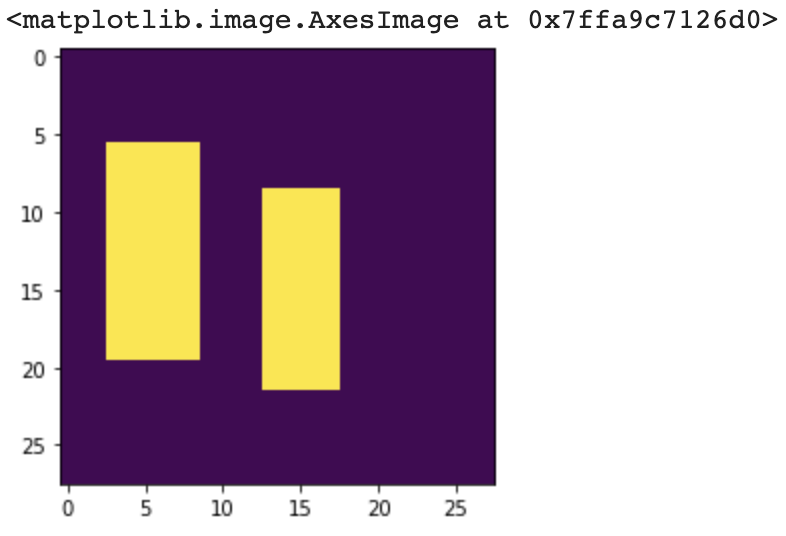

In [ ]:
pidtemp = class_train.iloc[[18]]['patientId']

In [ ]:
#show_dicom_images_with_boxes(label_data[label_data['patientId']==pidtemp])

In [ ]:
from tqdm import tqdm
def process_dicom_data(data_df):
    for n, pid in tqdm(enumerate(data_df['patientId'].unique())):
        # the patientId can have multiple bounding boxes 
        # so there could be different row for each of the bounding box. we jus take the unique patient ids       
        dcm_file = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid #each image file provided are named with patient id
        dcm_data = dcm.read_file(dcm_file)   #read the file using pydicom
        idx = (data_df['patientId']==dcm_data.PatientID)
        data_df.loc[idx,'Modality'] = dcm_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(dcm_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = dcm_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
        
    return data_df

In [ ]:
dicom_df = process_dicom_data(df)

In [ ]:
dicom_df = dicom_df.astype({"PatientAge": int})
dicom_df.fillna(0.0, inplace=True)
dicom_df.head()

In [ ]:
dicom_df.dtypes

In [ ]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'PatientAge', hue = 'Target', data = dicom_df)
plt.show()

In [ ]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = dicom_df)
plt.show()

**Model Creation**

**Model I : U-Net**

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model, load_model

In [ ]:
ALPHA = 1

In [ ]:
#this function will creat U-net model
def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model = create_model(False)
model.summary()

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [ ]:
X_train.shape

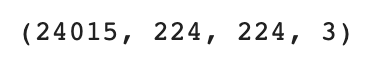

In [ ]:
y_train.shape

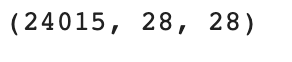

In [ ]:
X_val.shape

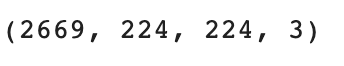

In [ ]:
y_val.shape

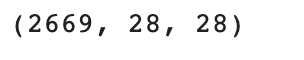

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=2)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=8, batch_size=12, verbose=1, callbacks=[checkpoint, stop, reduce_lr])

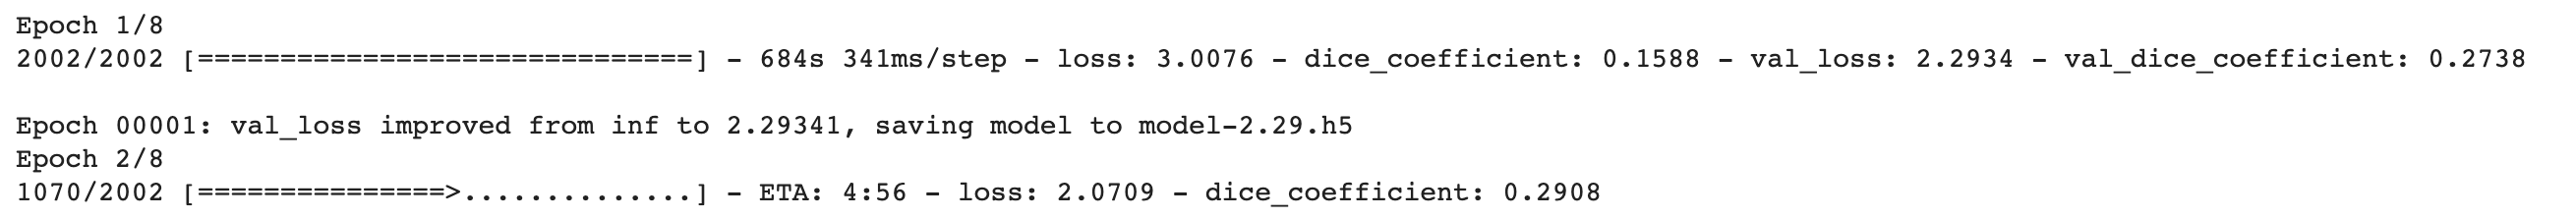

In [ ]:
mask_predicated = model.predict(X_val)

**Model II: Faster RCNN**

In [ ]:
%%writefile model.py
"""
Python script to prepare FasterRCNN model.
"""

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import  FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def model():
    # load the COCO pre-trained model
    # we will keep the image size to 1024 pixels instead of the original 800,
    # this will ensure better training and testing results, although it may...
    # ... increase the training time (a tarde-off)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                                 min_size=1024)
    # one class is pneumonia, and the other is background
    num_classes = 2
    # get the input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace pre-trained head with our features head
    # the head layer will classify the images based on our data input features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
%%writefile dataset.py

"""
Python script to prepare the dataset
"""

import numpy as np
import cv2
import re
import torch

from torch.utils.data import Dataset

class RSNADataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['patientId'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['patientId'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['patientId'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
%%writefile engine.py

import pandas as pd
import dataset
import albumentations as A
import time
import torch

import numpy as np
from sklearn import metrics
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

"""
Complete mAP code here => https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734
"""

def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None
    TP,FP,FN,TN = 0,0,0,0

    for threshold in thresholds:
        precision_at_threshold,tp ,fp ,fn ,tn  = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold
        TP += tp
        FP += fp
        FN += fn
        TN += tn
    accuracy = (TP + FP)/(TP+FP+FN+TN)
    return image_precision,TP/4, FP/4, FN/4, TN/4 , accuracy


def calculate_iou(gt, pr, form='pascal_voc') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )
    #print("IOU Calculated... "+str(overlap_area / union_area))
    return overlap_area / union_area


def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    
    fn = (gts.sum(axis=1) > 0).sum()
    tn = (gts.sum(axis=1) < 0).sum()

    return tp / (tp + fp + fn) ,tp ,fp ,fn ,tn


# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

def prepare_data():
    DIR_INPUT = '../input/rsna-pneumonia-detection-2018/input'
    DIR_TRAIN = f"{DIR_INPUT}/images/"

    train_df = pd.read_csv(f"{DIR_INPUT}/stage_2_train_labels.csv")
    print(train_df.shape)
    train_df.head()

    train_df_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

    k = 0
    for i in range(len(train_df)):
        if train_df.loc[i]['Target'] == 1:
            train_df_pos.loc[k] = train_df.loc[i]
            k += 1

    image_ids = train_df_pos['patientId'].unique()
    valid_ids = image_ids[-300:]
    train_ids = image_ids[:-300]
    print(f"Training instance: {len(train_ids)}")
    print(f"Validation instances: {len(valid_ids)}")

    valid_df = train_df_pos[train_df_pos['patientId'].isin(valid_ids)]
    train_df = train_df_pos[train_df_pos['patientId'].isin(train_ids)]

    valid_df.shape, train_df.shape
    
    train_dataset = dataset.RSNADataset(train_df, DIR_TRAIN, get_train_transform())
    valid_dataset = dataset.RSNADataset(valid_df, DIR_TRAIN, get_valid_transform())
    
    return train_dataset, valid_dataset
    
def get_data_loader(batch_size):
    
    train_dataset, valid_dataset = prepare_data()
    
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4, # else showing broken pipe error
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4, # else showing broken pipe error
        collate_fn=collate_fn
    )
    return train_data_loader, valid_data_loader

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
def train(dataloader, lr_scheduler, model, optimizer, 
          device, epoch, loss_hist, itr):
    model.train()
    start = time.time()
    loss_hist.reset()
    for images, targets, image_ids in dataloader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)


        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Epoch #{epoch} iteration #{itr} loss: {loss_value}")

        itr += 1
    
    end = time.time()
    return loss_hist, end, start

def validate(dataloader, model, device, iou_thresholds):
    valid_image_precision = []
    valid_accuracy = []
    v_TP, v_FP, v_FN, v_TN = [],[],[],[]
    model.eval()
    with torch.no_grad():
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
    #print(outputs)
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = boxes[preds_sorted_idx]
        image_precision, TP, FP, FN,TN, accuracy = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')
        valid_image_precision.append(image_precision)
        valid_accuracy.append(accuracy)
        v_TP.append(TP)
        v_FP.append(FP)
        v_FN.append(FN)
        v_TN.append(TN)
    valid_prec = np.mean(valid_image_precision)
    valid_acc = np.mean(valid_accuracy)
    cmat = [[v_TP, v_FN], [v_FP, v_TN]]
    return valid_prec, cmat, valid_acc

In [ ]:
%%writefile train.py

import torch
import engine
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import seaborn as sns
from engine import get_data_loader, Averager, train, validate
from model import model
# from torch.utils.data.sampler import SequentialSampler

matplotlib.style.use('ggplot')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

parser = argparse.ArgumentParser()
parser.add_argument('-s', '--show-sample', dest='show_sample', default='no', 
                 help='whether to visualize a wheat sample with bboxes or not')
args = vars(parser.parse_args())

# learning parameters
num_epochs = 1
lr = 0.001
batch_size = 8

model = model().to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.01)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# initialize the Averager
loss_hist = engine.Averager()
# get the dataloader
train_data_loader, valid_data_loader = get_data_loader(batch_size)

if args['show_sample'] == 'yes':
    images, targets, image_ids = next(iter(train_data_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[2].permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    
    ax.set_axis_off()
    ax.imshow(sample)
    plt.show()

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

train_loss = []
precision = []
for epoch in range(num_epochs):
    itr = 1
    train_loss_hist, end, start = train(train_data_loader, lr_scheduler,
                                        model, optimizer, device,
                                        epoch, loss_hist, itr)
    valid_prec, cmat, valid_acc = validate(valid_data_loader, model, device, iou_thresholds)
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()
    print(f"Took {(end-start)/60:.3f} minutes for epoch# {epoch} to train")
    print(f"Epoch #{epoch} Train loss: {train_loss_hist.value}")  
    print(f"Epoch #{epoch} Validation Precision: {valid_prec}")  
    train_loss.append(train_loss_hist.value)
    precision.append(valid_prec)
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# plot and save the training loss
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

# plot and save the validation precision
plt.figure()
plt.plot(precision, label='Validation precision')
plt.legend()
plt.show()
plt.savefig('precision.png')

In [ ]:
!python train.py --show-sample yes

In [ ]:
!zip fasterrcnn.zip 

In [ ]:
%%writefile test.py
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGeneratoar
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

DIR_INPUT = '../input/rsna-pneumonia-detection-2018/input'
DIR_TEST = f"{DIR_INPUT}/samples"
test_images = os.listdir(DIR_TEST)
print(f"Validation instances: {len(test_images)}")

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=1024)
num_classes = 2  # 1 class (pnueomonia) + background
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

os.makedirs('../validation_predictions', exist_ok=True)
model.load_state_dict(torch.load('../input/rsna-pytorch-hackathon-fasterrcnn-resnet-training/fasterrcnn_resnet50_fpn.pth'))
model.to(device)

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], 
                                                             int(j[1][0]), int(j[1][1]), 
                                                             int(j[1][2]), int(j[1][3])))

    return " ".join(pred_strings)

detection_threshold = 0.9
img_num = 0
results = []
model.eval()
with torch.no_grad():
    for i, image in tqdm(enumerate(test_images), total=len(test_images)):

        orig_image = cv2.imread(f"{DIR_TEST}/{test_images[i]}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cuda()
        image = torch.unsqueeze(image, 0)

        model.eval()
        cpu_device = torch.device("cpu")

        outputs = model(image)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
                
            for box in draw_boxes:
                cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 3)
        
            plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.savefig(f"{test_images[i]}")
            plt.close()
                
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': format_prediction_string(boxes, scores)
            }
            results.append(result)
        else:
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': None
            }
            results.append(result)

sub_df = pd.DataFrame(results, columns=['patientId', 'PredictionString'])
print(sub_df.head())
sub_df.to_csv('submission.csv', index=False)

In [ ]:
!python test.py

In [ ]:
from IPython.display import Image
Image(filename='./loss.png')


In [ ]:
Image(filename='./precision.png')

**Model III : DenseNet**

In [ ]:
LR = 0.005
EPOCHS = 2
BATCHSIZE = 32
CHANNELS = 64
IMAGE_SIZE = 256
NBLOCK = 6 
DEPTH = 2
MOMENTUM = 0.9

from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import os
from matplotlib import pyplot as plt

In [ ]:
import csv
import random
# Load pneumonia locations

# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]
                
                
# Load filenames

# load and shuffle filenames
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
filenames = filenames[:2000]
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[:1800]
valid_filenames = filenames[1800:]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

In [ ]:
# Data generator

class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # default negative
        target = 0
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            target = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, target
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, targets = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            targets = np.array(targets)
            return imgs, targets
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
# Network

def convlayer(channels, inputs, size=3, padding='same'):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, size, padding=padding, use_bias=False)(x)
    return x

def just_downsample(inputs, pool=2):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(pool)(x)
    return x

def convblock(inputs, channels1, channels2):
    x = convlayer(channels1, inputs)
    x = convlayer(channels2, x)
    x = keras.layers.Concatenate()([inputs, x])
    return x

def denseblock(inputs, nblocks=6, channels1=128, channels2=32):
    x = inputs
    for i in range(nblocks):
        x = convblock(x, channels1, channels2)
    x = keras.layers.SpatialDropout2D(.2)(x)
    return x

def transition(inputs, channels, pool=2):
    x = convlayer(channels, inputs)
    x = keras.layers.AveragePooling2D(pool)(x)
    return x
    
def create_network(input_size, channels=64, channels2=32, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=2, use_bias=False)(inputs)
    x = just_downsample(x)

    # densenet blocks
    nchan = channels
    for d in range(depth-1):
        x = denseblock(x)
        nchan = ( nchan + n_blocks*channels2 ) // 2
        x = transition(x, nchan)
    x = denseblock(x)

    # output
    x = convlayer(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Dropout(.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=LR),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, 
                              epochs=EPOCHS, shuffle=True, verbose=2)

In [ ]:

gc.collect()